<h3>Step 1: Import libraries</h3>

In [32]:
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix, accuracy_score, roc_curve, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
import pickle
import os

warnings.filterwarnings('ignore')

<h3>Step 2: Import data</h3>

In [33]:
# Read dataset
processed_data = os.path.abspath('../datasets/processed_data.csv')

# merging two csv files
dataframe = pd.read_csv(processed_data)

dataframe.head()

,Location,Day,Hour,AQI,PM2.5,PM10,O3,CO,SO2,NO2,AQI_Class
0,0,26,18,48,24.0,47.0,17.0,210.0,13.0,14.0,a_Good
1,7,22,20,36,18.0,28.0,8.0,346.0,27.0,7.0,a_Good
2,0,28,18,37,19.0,37.0,18.0,272.0,11.0,21.0,a_Good
3,0,28,18,37,19.0,37.0,18.0,272.0,11.0,21.0,a_Good
4,0,27,18,47,24.0,46.0,19.0,216.0,8.0,14.0,a_Good


<h3>Step 3: Split data</h3>

In [34]:
# Transforming categorical variables
label_encoder = LabelEncoder()
dataframe['AQI_Class'] = label_encoder.fit_transform(dataframe['AQI_Class'])

# Selecting features and target variable
X = dataframe[['Location', 'Day', 'Hour', 'PM2.5', 'PM10', 'O3', 'CO', 'SO2', 'NO2']]
y = dataframe['AQI_Class']

# Data scaling
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Splitting into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<h3>Step 4: Feature scaling</h3>

In [35]:
# Scale dataset
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

<h3>Step 5: Train model</h3>

In [36]:
# XG Boost Classification
classifier = xgboost.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
classifier.fit(X_train, y_train)

AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

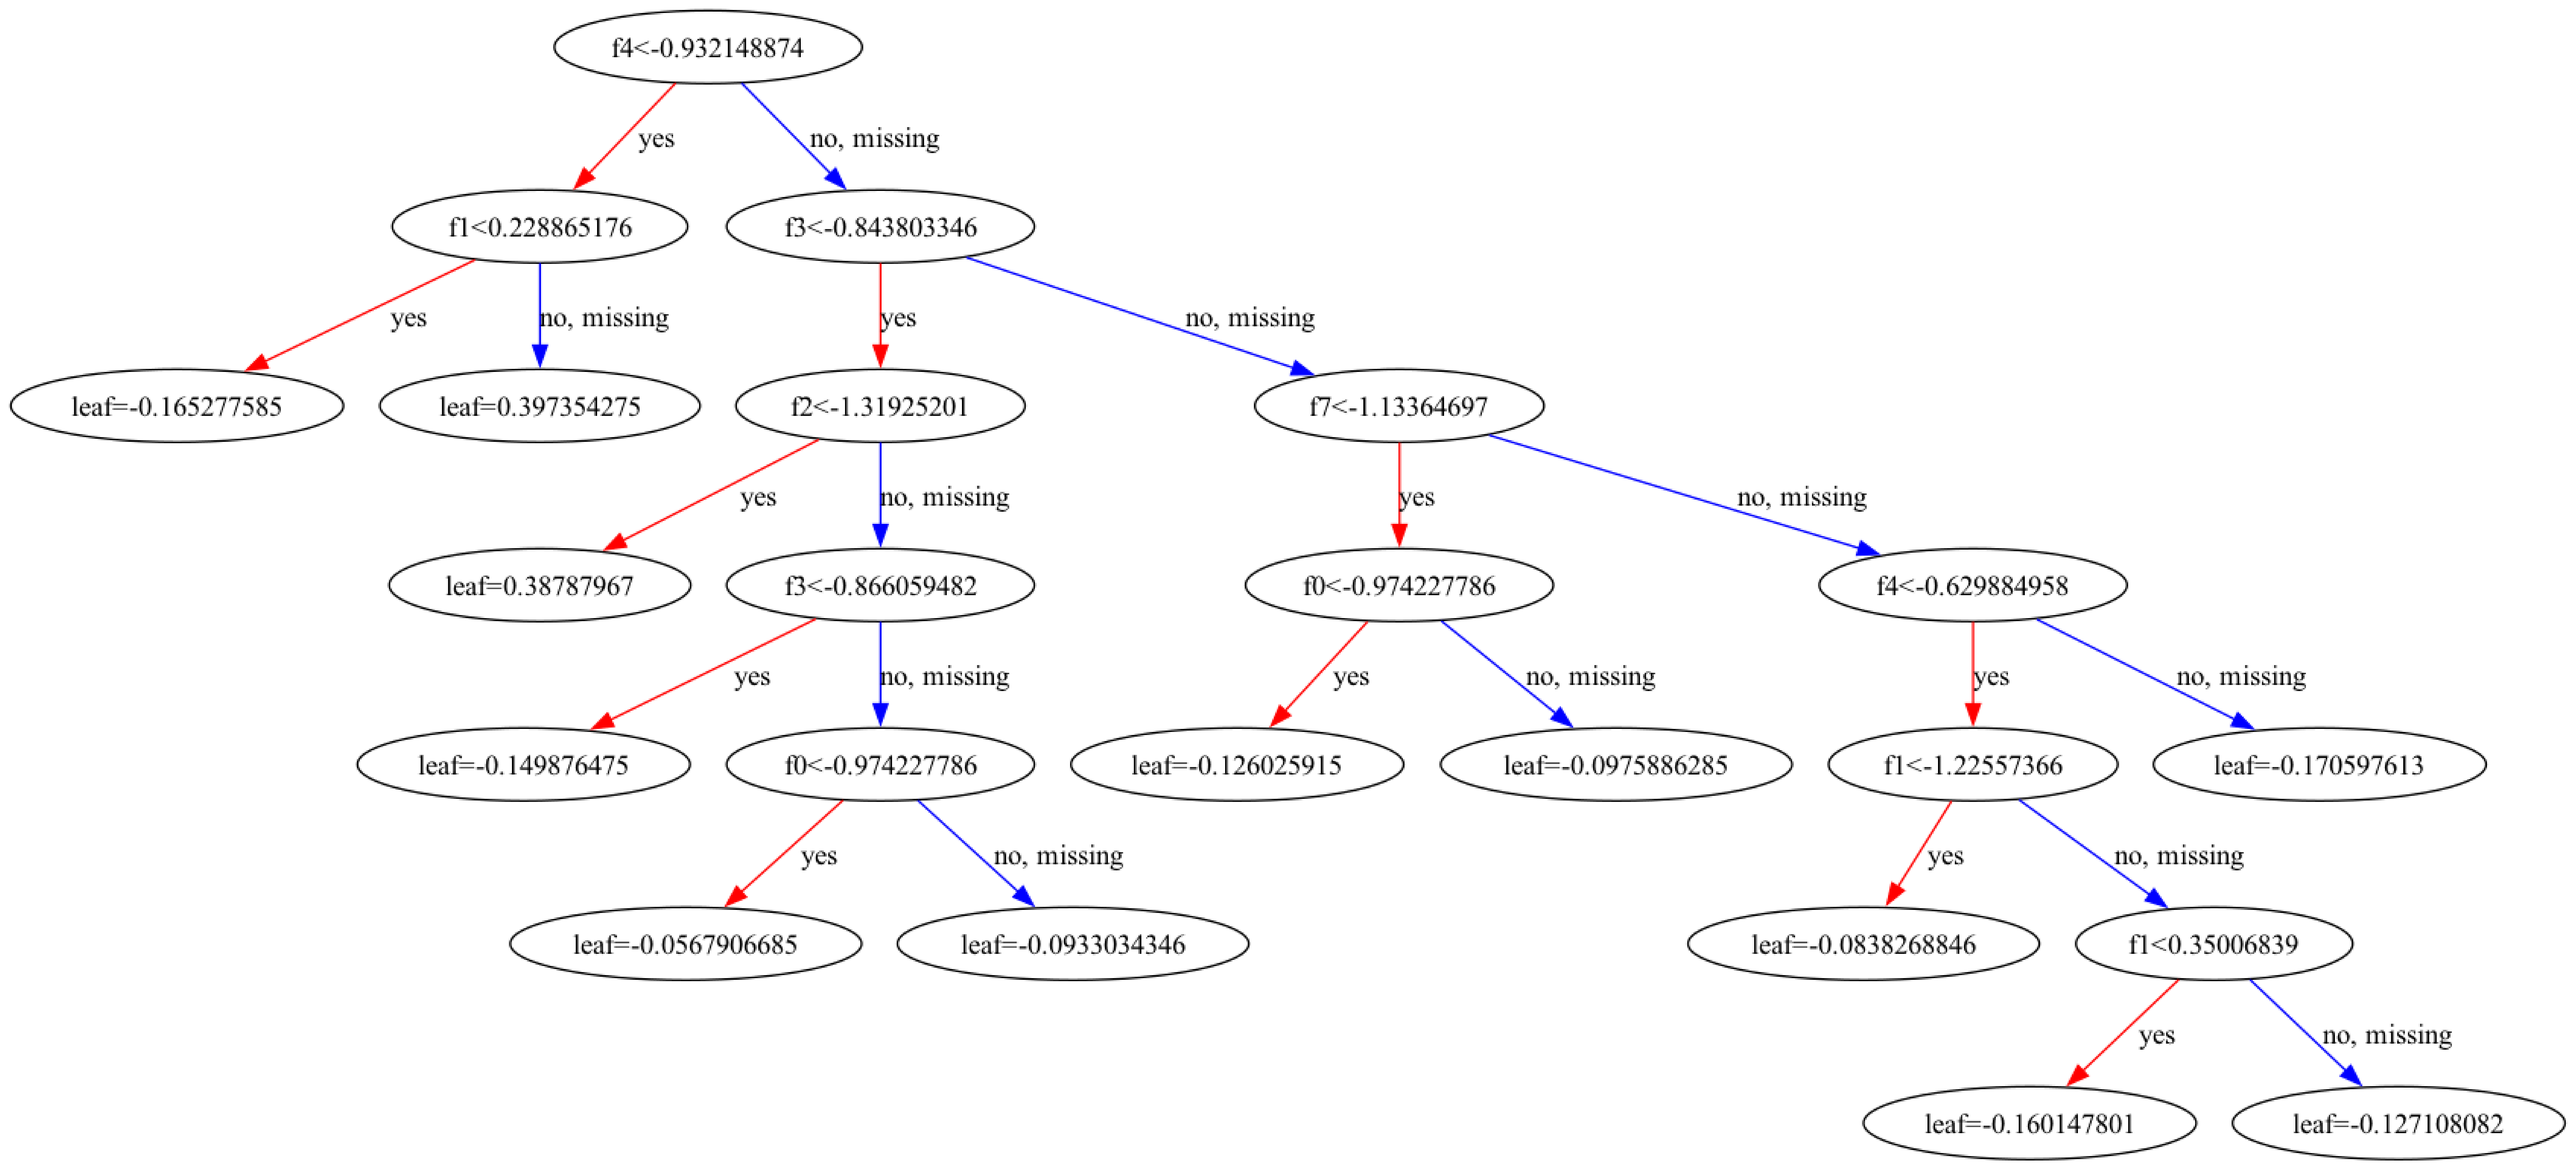

In [37]:
fig, ax = plt.subplots(figsize=(120, 120))
xgboost.plot_tree(classifier, num_trees=6, ax=ax)
plt.show()

<h3>Step 6: Predict result / Score model</h3>

In [38]:
# Model performance on training set
y_pred_train = classifier.predict(X_train)
y_pred_test = classifier.predict(X_test)

<h3>Step 7: Evaluate model</h3>

<b>Accuracy</b>

In [39]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred_test)
print("Accuracy: {:.2f}".format(accuracy))

Accuracy: 0.97


<b>Classification report</b>

In [40]:
# Classification report
print(classification_report(y_train, y_pred_train, target_names=list(label_encoder.classes_)))

                                  precision    recall  f1-score   support

                          a_Good       0.97      0.96      0.96      1252
                      b_Moderate       0.97      0.97      0.97      1259
c_Unhealthy_for_Sensitive_Groups       0.96      0.97      0.97      2252
                     d_Unhealthy       0.98      0.97      0.97      2117
                e_Very_Unhealthy       0.97      0.97      0.97      1763
                        f_Severe       0.95      0.98      0.96      1149

                        accuracy                           0.97      9792
                       macro avg       0.97      0.97      0.97      9792
                    weighted avg       0.97      0.97      0.97      9792



<b>F1 score</b>

In [41]:
# F1 score
print("F1 Score: ", f1_score(y_train, y_pred_train, average='micro'))

F1 Score:  0.9683415032679739


<b>Confusion matrix</b>

<Axes: >

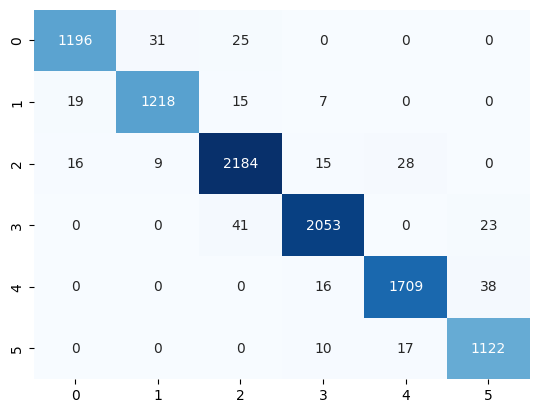

In [42]:
# Confusion matrix
cf_matrix = confusion_matrix(y_train, y_pred_train)
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)

<b>Precision-Recall curve</b>

In [43]:
# multi-class classification
# fit model
clf = OneVsRestClassifier(LogisticRegression())
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
pred_prob = clf.predict_proba(X_test)

category_mapping = {
    'a_Good': 'Good',
    'b_Moderate': 'Moderate',
    'c_Unhealthy_for_Sensitive_Groups': 'USG', 
    'd_Unhealthy' : 'Unhealthy',
    'e_Very_Unhealthy' : 'Very Unhealthy',
    'f_Severe' : 'Severe'
}

n_class = 6

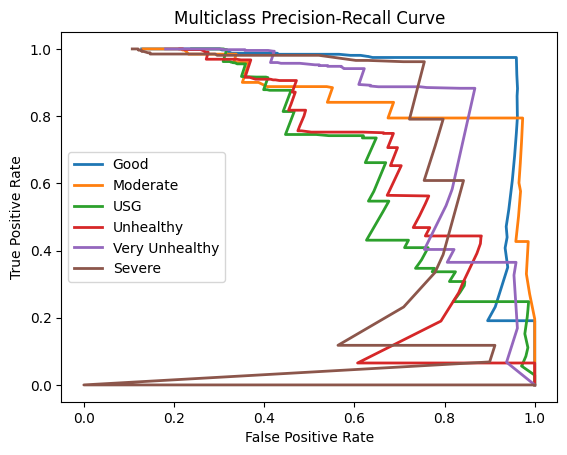

In [44]:
# Plot Precision-Recall Curve
fpr = {}
tpr = {}
thresh = {}

for i in range(n_class):
    fpr[i], tpr[i], thresh[i] = precision_recall_curve(y_test, pred_prob[:, i], pos_label=i)
    plt.plot(fpr[i], tpr[i], lw=2, label='{}'.format(category_mapping[list(label_encoder.classes_)[i]]))

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="best")
plt.title("Multiclass Precision-Recall Curve")
plt.show()

<b>AUC/ROC curve</b>

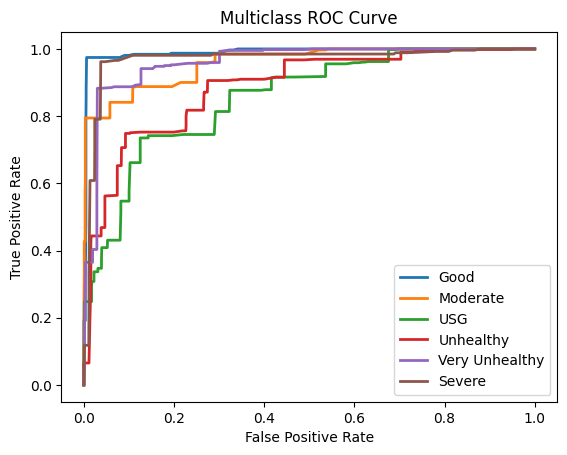

In [45]:
# Plot AUC/ROC curve
fpr = {}
tpr = {}
thresh = {}

for i in range(n_class):
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, pred_prob[:, i], pos_label=i)
    plt.plot(fpr[i], tpr[i], lw=2, label='{}'.format(category_mapping[list(label_encoder.classes_)[i]]))

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="best")
plt.title("Multiclass ROC Curve")
plt.show()

<h3>Step 8: Feature scaling</h3>

Serialize XG Boost Model in pickle file.

In [46]:
with open('serialized/XGBoostModel.pkl', 'wb') as file:
    pickle.dump(classifier, file)